In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
from collections import Counter

In [3]:
import sys
sys.path.append('..')

from util.participant_stream import ParticipantStream

# Algo 1
Greedy algorithm that weights samples with lower probability greater
1. randomly sample from participant pool and build distribution
2. compute kde over this space
3. for each sample, assign weight equals to probability of sample from kde
4. assign in order from lowest probability first

## Basic Proof of Concept
For first run, we will ignore the arrival times and assume we have full pool available and see how the algorithm does assuming perfect information of pool to get a baseline.

In [4]:
rng = np.random.default_rng(3098)

In [5]:
stream = ParticipantStream(rng=rng)
pool = stream.generate_participants(5000)

In [6]:
# sample from pool to build distribution
ages = np.fromiter((p['age'] for p in pool), dtype=int)
sampled_pairs = rng.choice(ages, (2, 10000))
sampled_pairs

array([[40, 32, 53, ..., 47, 44, 38],
       [48, 58, 46, ..., 24, 47, 42]])

In [7]:
sample_p = stats.gaussian_kde(sampled_pairs)

In [35]:
sample_pdf = sample_p(sampled_pairs)

In [36]:
sample_p_comp = stats.gaussian_kde(sampled_pairs, weights=1 - sample_pdf)

In [29]:
all_pairs = combinations(ages, 2)
all_pairs = set(all_pairs)
all_pairs

{(67, 59),
 (26, 21),
 (59, 55),
 (78, 68),
 (79, 33),
 (70, 64),
 (71, 29),
 (63, 25),
 (36, 71),
 (28, 67),
 (29, 32),
 (48, 45),
 (40, 41),
 (60, 19),
 (63, 61),
 (29, 68),
 (75, 35),
 (21, 64),
 (40, 77),
 (41, 42),
 (33, 38),
 (73, 74),
 (52, 51),
 (25, 34),
 (44, 47),
 (72, 29),
 (64, 25),
 (56, 21),
 (22, 28),
 (74, 75),
 (66, 71),
 (67, 36),
 (59, 32),
 (32, 78),
 (78, 45),
 (24, 74),
 (70, 41),
 (36, 48),
 (55, 61),
 (47, 57),
 (48, 22),
 (59, 68),
 (79, 46),
 (70, 77),
 (71, 42),
 (63, 38),
 (29, 45),
 (48, 58),
 (21, 41),
 (40, 54),
 (41, 19),
 (60, 32),
 (52, 28),
 (44, 24),
 (62, 78),
 (54, 74),
 (74, 52),
 (25, 47),
 (66, 48),
 (45, 25),
 (32, 55),
 (37, 21),
 (51, 68),
 (78, 22),
 (43, 64),
 (35, 60),
 (55, 38),
 (47, 34),
 (67, 49),
 (59, 45),
 (78, 58),
 (79, 23),
 (70, 54),
 (71, 19),
 (36, 61),
 (28, 57),
 (29, 22),
 (47, 70),
 (48, 35),
 (40, 31),
 (42, 77),
 (75, 25),
 (21, 54),
 (62, 55),
 (41, 32),
 (54, 51),
 (33, 28),
 (73, 64),
 (74, 29),
 (25, 24),
 (44, 37),

In [10]:
len(all_pairs)

12497500

In [37]:
test2 = sample_p_comp.resample(1000, seed=rng).astype(int)

In [ ]:
test2

In [34]:
test = np.zeros((2, 1000))
next_idx = 0
while len(test) < 1000:
    temp = sample_p.resample(1, seed=rng).astype(int)
    if tuple(temp[0]) in all_pairs:
        test[0, next_idx] = temp[0]
        test[1, next_idx] = temp[1]
        next_idx += 1
test

KeyboardInterrupt: 

In [11]:
import timeit

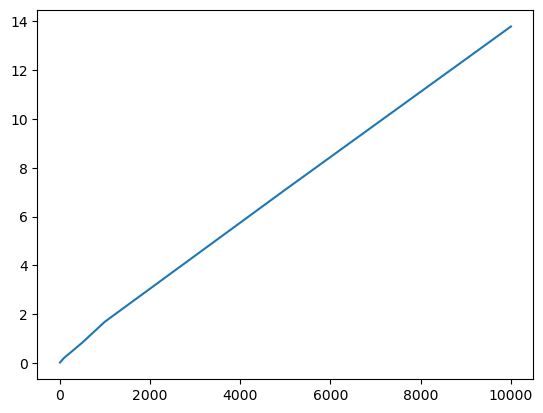

In [15]:
sizes = [10, 100, 500, 1000, 5000, 10000]
rt = []
for size in sizes:
    rt.append(timeit.timeit(lambda: sample_p(np.array(all_pairs[:size]).transpose()), number=10))
plt.plot(sizes, rt)
plt.show()

In [ ]:
all_pairs_prob = sample_p(np.array(all_pairs).transpose())

In [ ]:
true_best = all_pairs[np.argsort(all_pairs_prob.astype(int))]
true_best

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
for i in range(10):
    print(true_best[i], sample_p[true_best[i]])

In [38]:
def greedy_pairs(pair_list, pool):
    age_map = {}
    for p in pool:
        if p['age'] not in age_map:
            age_map[p['age']] = [p]
        else:
            age_map[p['age']].append(p)
        grouping = []
    for pair in pair_list:
        p1 = int(pair[0])
        p2 = int(pair[1])
        if p1 > p2:
            p1, p2 = p2, p1
        if p1 not in age_map or p2 not in age_map:
            continue
        if p1 == p2 and len(age_map[p1]) < 2:
            continue
        grouping = (age_map[p1].pop(), age_map[p2].pop())
        if len(age_map[p1]) == 0:
            del age_map[p1]
        if p2 != p1 and len(age_map[p2]) == 0:
            del age_map[p2]
        if not age_map:
            break
    return grouping

In [ ]:
true_grouping = greedy_pairs(true_best, pool)

In [ ]:
test_prob = sample_p(test)
test_prob

array([0.00073812, 0.00043618, 0.00058176, ..., 0.0003516 , 0.00074632,
       0.00038723])

In [ ]:
test_pairs = test.transpose()[np.argsort(test_prob)]
test_pairs

array([[47.5570161 , 87.03267307],
       [12.98285162, 19.74973262],
       [38.71701722, 85.16759864],
       ...,
       [43.05957956, 42.64765895],
       [42.64897805, 42.0189686 ],
       [42.9364895 , 42.30550413]])

In [39]:
test2_prob = sample_p_comp(test2)
test2_prob

array([1.87616467e-04, 4.64202022e-04, 6.55160603e-04, 4.90876078e-04,
       2.37232783e-04, 5.03211603e-04, 7.99917689e-04, 5.47394187e-05,
       4.36833065e-04, 2.57259853e-04, 3.67985830e-04, 2.39709529e-04,
       3.01596876e-04, 3.61466187e-04, 2.91390545e-04, 3.54601766e-04,
       7.99917689e-04, 1.07922944e-04, 7.41931169e-04, 7.25815695e-04,
       2.12540839e-04, 7.94867076e-04, 7.60903882e-04, 7.23541133e-04,
       2.71989290e-04, 3.76106865e-04, 5.35277781e-04, 4.65414212e-04,
       7.98761373e-04, 7.87761256e-04, 2.00996334e-04, 6.88795886e-04,
       7.25815695e-04, 2.60830700e-04, 2.66458098e-04, 1.85056520e-05,
       3.40128869e-04, 1.76004706e-04, 6.53272997e-05, 6.13988372e-04,
       4.38212958e-04, 2.06143784e-04, 5.53314390e-04, 5.38161853e-04,
       3.16068630e-04, 4.68939125e-04, 6.54450088e-04, 4.07012117e-05,
       5.51922417e-04, 5.18547253e-04, 7.83213289e-04, 6.83671365e-04,
       1.15710921e-04, 7.22542772e-04, 2.18801824e-04, 4.37899415e-04,
      

In [40]:
test2_pairs = test2.transpose()[np.argsort(test2_prob)[::-1]]
test2_pairs

array([[43, 42],
       [43, 41],
       [44, 43],
       ...,
       [81, 61],
       [18, 18],
       [12, 43]])

In [42]:
test2_grouping = greedy_pairs(test2_pairs, pool)
test2_grouping

({'party': 'Republican',
  'age': 21,
  'gender': 'M',
  'arrival_time': 29,
  'departure_time': 42},
 {'party': 'Republican',
  'age': 78,
  'gender': 'F',
  'arrival_time': 22,
  'departure_time': 36})

In [ ]:
test_grouping = greedy_pairs(test_pairs, pool)
test_grouping

({'party': 'Democrat',
  'age': 42,
  'gender': 'M',
  'arrival_time': 14,
  'departure_time': 41},
 {'party': 'Democrat',
  'age': 42,
  'gender': 'M',
  'arrival_time': 14,
  'departure_time': 47})

We try a different strategy. Build KDE of pool and just greedily select participant with least probability of showing up based on kde. This is easier to compute and will probably scale better as the dimensions of the kde is much smaller.

In [ ]:
pop_p = stats.gaussian_kde(ages)

In [ ]:
rareness = pop_p(ages)
rareness

array([0.02740866, 0.01876117, 0.02817543, ..., 0.02680299, 0.02902373,
       0.02153773])

In [ ]:
ranked_idx = np.argsort(rareness)
ranked_idx

array([1469, 3684, 4559, ...,  708, 1555, 4803], dtype=int64)

In [ ]:
groupings = []
for i in range(0, len(pool), 2):
    i1 = ranked_idx[i]
    i2 = ranked_idx[i+1]
    if pool[i1]['age'] < pool[i2]['age']:
        groupings.append((pool[i1], pool[i2]))
    else:
        groupings.append((pool[i2], pool[i1]))
groupings

[({'party': 'Democrat',
   'age': 79,
   'gender': 'F',
   'arrival_time': 38,
   'departure_time': 48},
  {'party': 'Republican',
   'age': 79,
   'gender': 'F',
   'arrival_time': 12,
   'departure_time': 22}),
 ({'party': 'Democrat',
   'age': 79,
   'gender': 'M',
   'arrival_time': 29,
   'departure_time': 114},
  {'party': 'Democrat',
   'age': 79,
   'gender': 'F',
   'arrival_time': 79,
   'departure_time': 84}),
 ({'party': 'Democrat',
   'age': 79,
   'gender': 'M',
   'arrival_time': 27,
   'departure_time': 36},
  {'party': 'Democrat',
   'age': 79,
   'gender': 'M',
   'arrival_time': 15,
   'departure_time': 35}),
 ({'party': 'Republican',
   'age': 79,
   'gender': 'F',
   'arrival_time': 20,
   'departure_time': 41},
  {'party': 'Republican',
   'age': 79,
   'gender': 'F',
   'arrival_time': 54,
   'departure_time': 73}),
 ({'party': 'Democrat',
   'age': 79,
   'gender': 'F',
   'arrival_time': 6,
   'departure_time': 64},
  {'party': 'Republican',
   'age': 79,
   'g

In [ ]:
len(groupings)

2500